# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse NAc cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata
import scipy.io
import scipy.sparse

import time
import os, wget


import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import cuml
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)
from scipy import sparse
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()
import calculation_tool as ct

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

## load data

In [ ]:
import os
import scanpy as sc
import pandas as pd
from scipy import sparse
import anndata

def load_and_merge_data_v3(base_dir):
    # 処理する条件（controlとschizophrenia）をリストとして定義
    conditions = ['control', 'schizophrenia']
    
    count = 0
    for condition in conditions:
        condition_path = os.path.join(base_dir, condition)
        
        # 各条件下でのサンプル名（MB7、MB8など）を取得
        samples = os.listdir(condition_path)
        
        for sample in samples:
            sample_path = os.path.join(condition_path, sample, 'matrix.tsv')
            
            # pandasでTSVファイルを読み込み
            if count == 0:
                adata=sc.read_csv(sample_path,delimiter='\t').T
                sparse_X = sparse.csr_matrix(adata.X)
                adata.X = sparse_X
                adata.obs['condition'] = condition
                adata.obs['sample'] = sample
            else:
                adata_append = sc.read_csv(sample_path,delimiter='\t').T
                sparse_X = sparse.csr_matrix(adata_append.X)
                adata_append.X = sparse_X
                adata_append.obs['condition'] = condition
                adata_append.obs['sample'] = sample
            
                # 連結
                adata = anndata.concat([adata, adata_append])
                print(adata.X.shape)
            
            count += 1
            
    return adata

base_dir = '/temp/data/human_Sz_PFC_each'
#adata = load_and_merge_data_v3(base_dir)
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
#adata.write(file_path)

In [2]:
file_path="/data/human_Sz_PFC_each/merged_SZ_adata.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,is_gpu=False)
GPCR_df.to_csv("/data/human_Sz_PFC_each/SZ_combined_data_GPCR_df.csv")

preprocess_in_bulk
HTR1A is not included
HTR1A is removed from marker list
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2']
perform regression
perform scale


CUDADriverError: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered

In [12]:
file_path="/data/human_Sz_PFC_each/merged_control_adata.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,is_gpu=False)
GPCR_df.to_csv("/data/human_Sz_PFC_each/control_combined_data_GPCR_df.csv")

preprocess_in_bulk
HTR1A is not included
HTR1A is removed from marker list
CHRM4 is not included
CHRM4 is removed from marker list
ADRB2 is not included
ADRB2 is removed from marker list
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1']
perform regression


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /opt/conda/include/rmm/mr/device/cuda_memory_resource.hpp

preprocess_in_bulk
HTR1A is not included
HTR1A is removed from marker list
CHRM4 is not included
CHRM4 is removed from marker list
ADRA2B is not included
ADRA2B is removed from marker list
ADRB2 is not included
ADRB2 is removed from marker list
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2C', 'ADRB1']
perform regression
perform scale
float32
Total Preprocessing time: 55.58664560317993
shape of adata: (56884, 30310)
shape of adata: (56884, 30310)
perform PCA
10
t-sne
UMAP
[2025-04-10 09:12:24.344] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP louvain


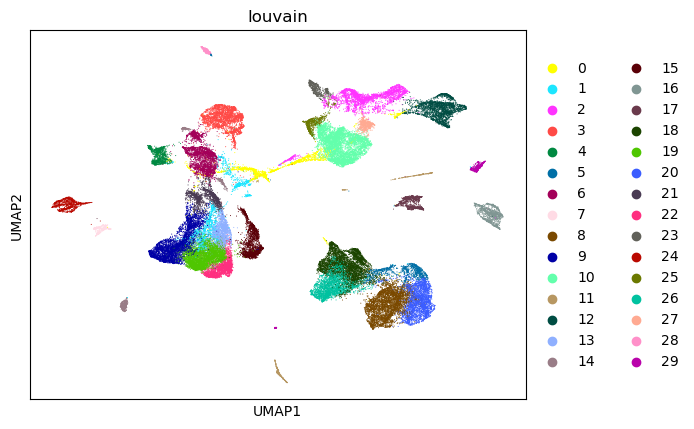

UMAP leiden


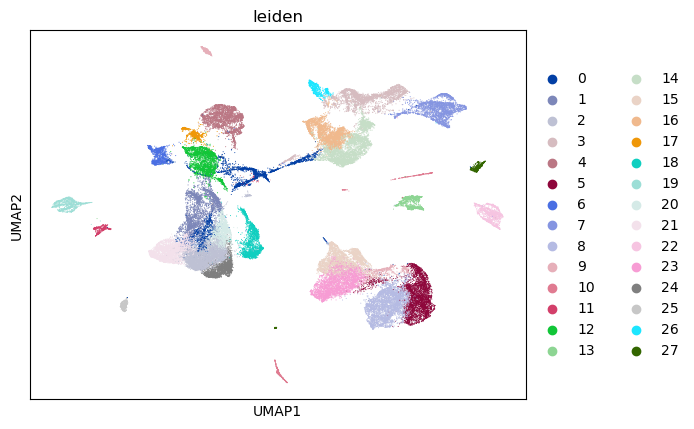

calc drug response
clz selective cells
# of clz selective cells: is_clz_selective
False    42646
True     14238
Name: count, dtype: int64


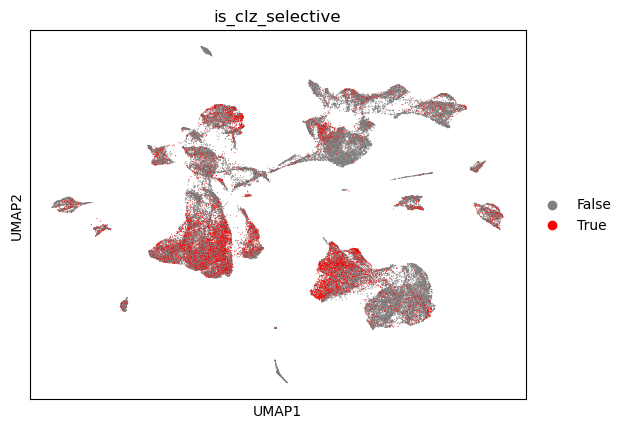

In [9]:
file_path="/data/human_Sz_PFC_each/merged_control_selected_adata.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,is_gpu=False)
GPCR_df.to_csv("/data/human_Sz_PFC_each/control_selected_combined_data_GPCR_df.csv")

Drug concentration: 0.001
clz selective cells
# of clz selective cells: is_clz_selective
False    54002
True      2882
Name: count, dtype: int64


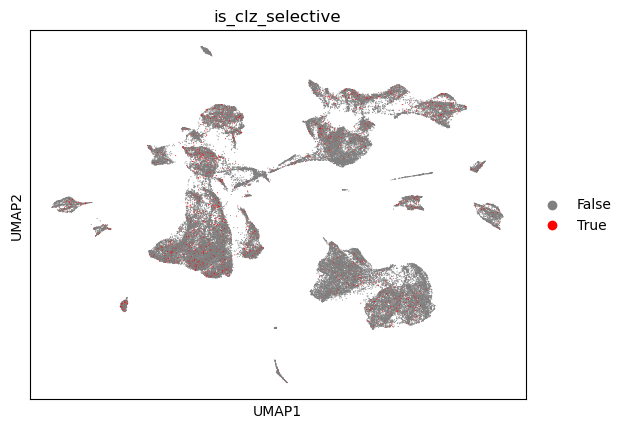

Drug concentration: 0.01
clz selective cells
# of clz selective cells: is_clz_selective
False    54002
True      2882
Name: count, dtype: int64


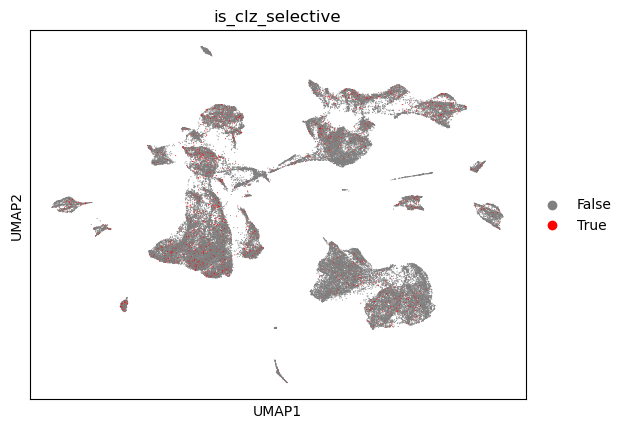

Drug concentration: 0.1
clz selective cells
# of clz selective cells: is_clz_selective
False    54001
True      2883
Name: count, dtype: int64


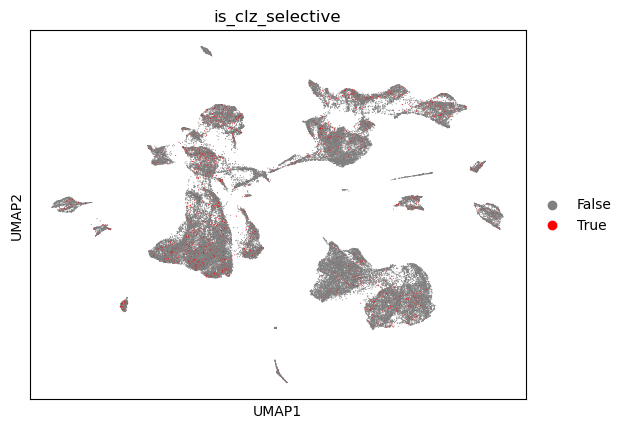

Drug concentration: 1
clz selective cells
# of clz selective cells: is_clz_selective
False    53932
True      2952
Name: count, dtype: int64


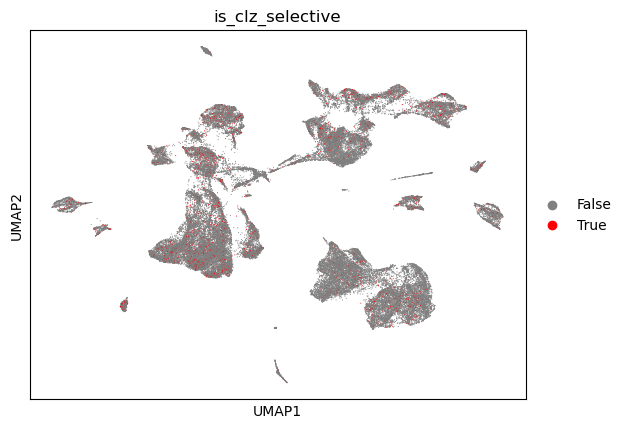

Drug concentration: 1.5848931924611136
clz selective cells
# of clz selective cells: is_clz_selective
False    53824
True      3060
Name: count, dtype: int64


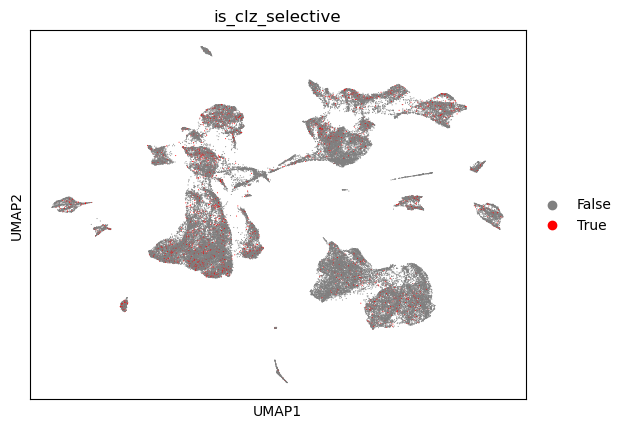

Drug concentration: 2.2387211385683394
clz selective cells
# of clz selective cells: is_clz_selective
False    53657
True      3227
Name: count, dtype: int64


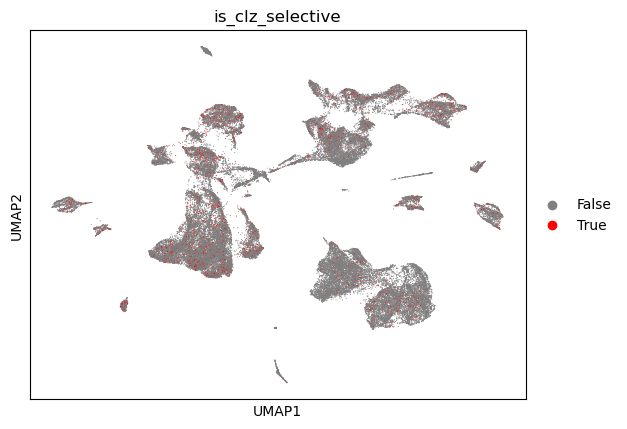

Drug concentration: 3.1622776601683795
clz selective cells
# of clz selective cells: is_clz_selective
False    53168
True      3716
Name: count, dtype: int64


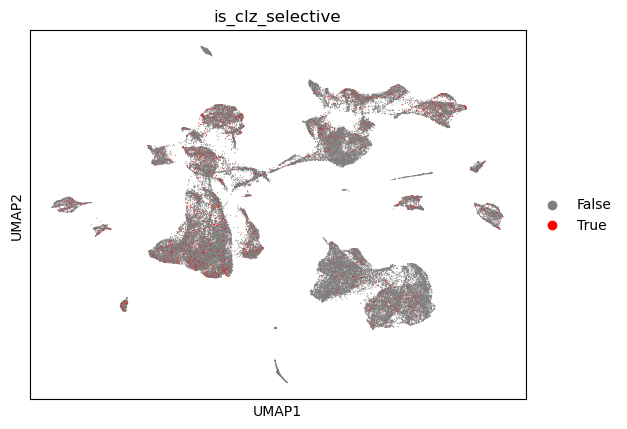

Drug concentration: 5.623413251903491
clz selective cells
# of clz selective cells: is_clz_selective
False    52720
True      4164
Name: count, dtype: int64


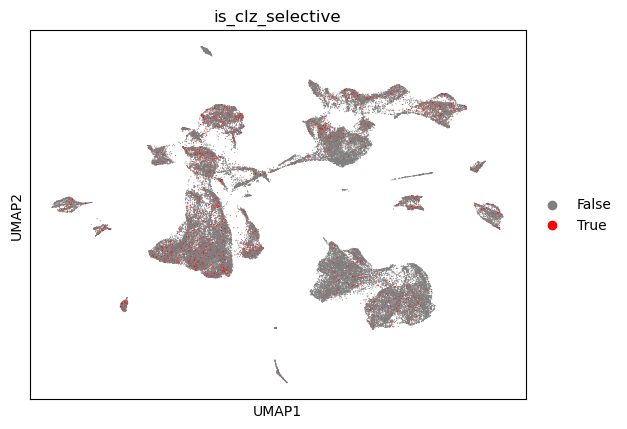

Drug concentration: 10
clz selective cells
# of clz selective cells: is_clz_selective
False    51950
True      4934
Name: count, dtype: int64


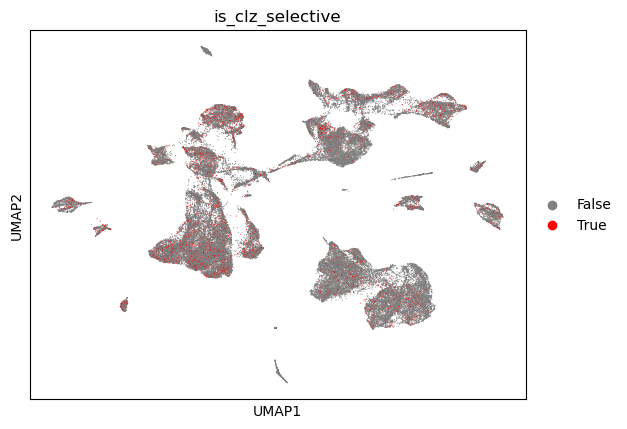

Drug concentration: 31.622776601683793
clz selective cells
# of clz selective cells: is_clz_selective
False    49691
True      7193
Name: count, dtype: int64


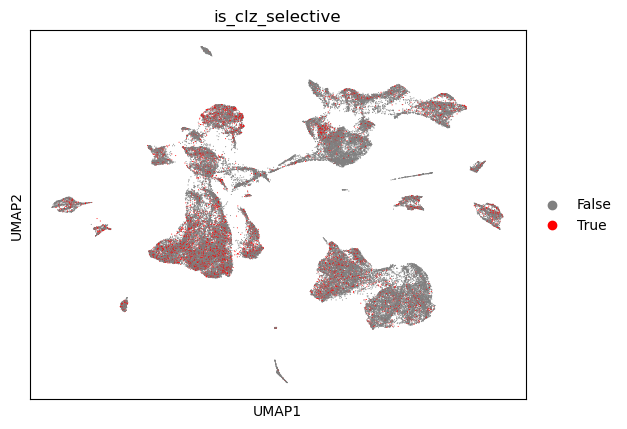

Drug concentration: 100
clz selective cells
# of clz selective cells: is_clz_selective
False    44654
True     12230
Name: count, dtype: int64


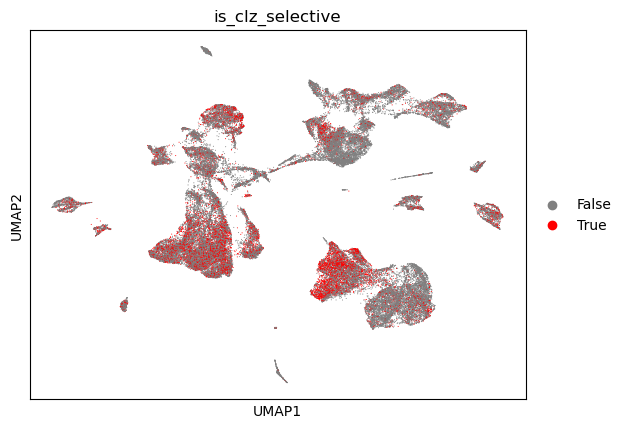

Drug concentration: 316.22776601683796
clz selective cells
# of clz selective cells: is_clz_selective
False    42785
True     14099
Name: count, dtype: int64


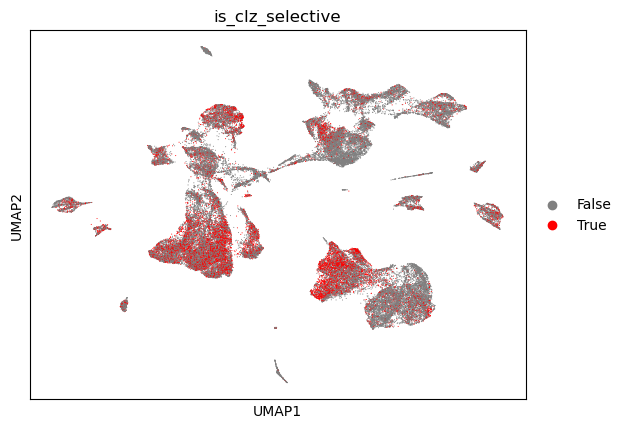

Drug concentration: 1000
clz selective cells
# of clz selective cells: is_clz_selective
False    41193
True     15691
Name: count, dtype: int64


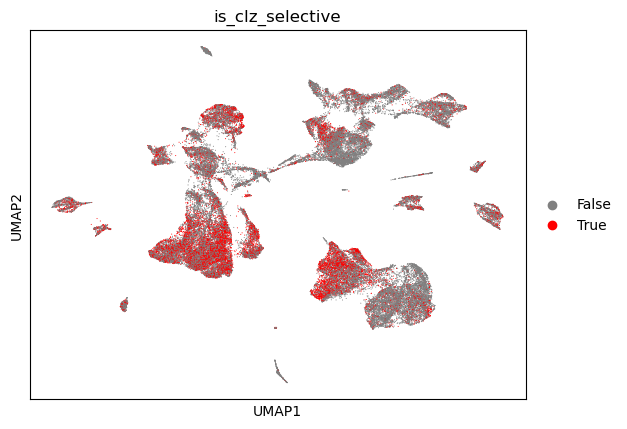

Drug concentration: 10000
clz selective cells
# of clz selective cells: is_clz_selective
False    41055
True     15829
Name: count, dtype: int64


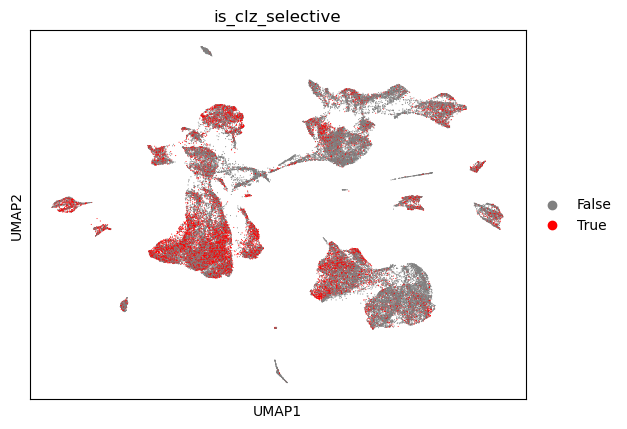

Drug concentration: 100000
clz selective cells
# of clz selective cells: is_clz_selective
False    48794
True      8090
Name: count, dtype: int64


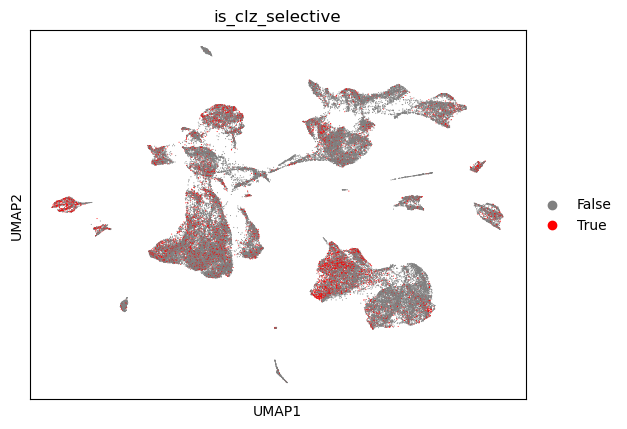

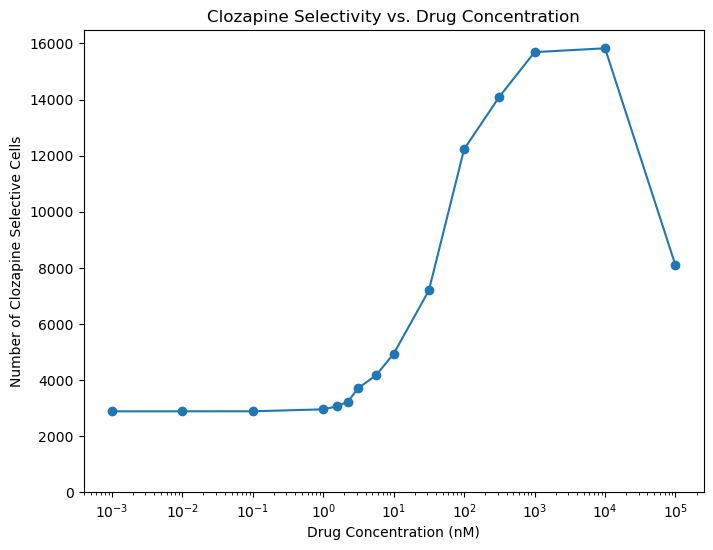

In [10]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)
import calculation_tool as ct
ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

In [ ]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)